In [1]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

from scipy import integrate

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# delta scan
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/delta_scan/DNT_dn0p6')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/delta_scan/DPT_d0p6')

# nuscan
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DPT_nu0p1')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DPT_nu1')

#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DNT_nu0p1')
os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/nu_scan/DNT_nu1')

# stscan 
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/st_scan/DPT_st0p05')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/st_scan/DPT_st0p3')

#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/st_scan/DNT_st0p05')
#os.chdir('/marconi/home/userexternal/klim0000/scratch/GBS/DN_tria/st_scan/DNT_st0p3')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/3_GBS_DN_Tria


In [2]:
t_final = s.time[-1]
t_init = t_final -10

tempe = s.get_field('Te', t1=t_init, t2=t_final)
dens = s.get_field('n', t1=t_init, t2=t_final)

tempe = np.mean(tempe, axis=(2,3))
dens = np.mean(dens, axis=(2,3))

In [3]:
# Source parameters
x0n = s.attribute['x0_EC_theta']
x0t = s.attribute['x0_EC_tempe']
ix0n = s.find_ind(s.x0 + x0n, s.x)
ix0t = s.find_ind(s.x0 + x0t, s.x)

# Width of the source
wn = s.attribute['wEC_theta']
wt = s.attribute['wEC_tempe']


# Amplitude of the source
An = s.attribute['SEC_theta']
At = s.attribute['SEC_tempe']

Psi = s.Psi
psi0n = Psi[s.iy0, ix0n]
psi0t = Psi[s.iy0, ix0t]

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)
ixxpt = Xpt_coord[0]
iyxpt = Xpt_coord[1]
#psi_xpt = s.Psi[s.iyxpt, s.ixxpt]

# Compute source

In [4]:
# Density source (Local flux)
Sn = [[0 for x in range(s.nx)] for y in range(s.ny)]
St = [[0 for x in range(s.nx)] for y in range(s.ny)]

for j in range(s.nx):
    for i in range(s.ny):
        if (i > s.iyxpt) and (i< (s.ny-s.iyxpt)):
            Sn[i][j]=An*np.exp(-(Psi[i][j] - psi0n)**2/wn**2) 
            St[i][j] = At/2 * (np.tanh(-(Psi[i][j] - psi0t)/wt) + 1)

# Power source
Sp = dens * St + tempe * Sn

# List to array
Sn = np.array(Sn); St = np.array(St); Sp = np.array(Sp)

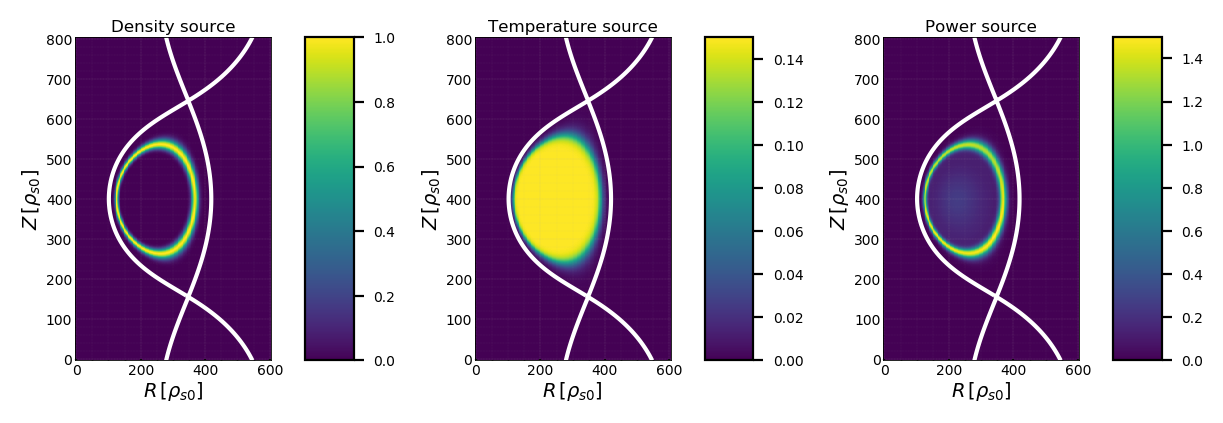

In [5]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=3,  figsize=(6, 2),  dpi=200, constrained_layout=True)

cs1 = axes[0].pcolormesh(X, Y, Sn, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, St, cmap='viridis')
cs3 = axes[2].pcolormesh(X, Y, Sp, cmap='viridis')

axes[0].set_title('Density source', size=6, pad=2)
axes[1].set_title('Temperature source', size=6, pad=2)
axes[2].set_title('Power source', size=6, pad=2)

cbar1=fig.colorbar(cs1, ax=axes[0])
cbar2=fig.colorbar(cs2, ax=axes[1])
cbar3=fig.colorbar(cs3, ax=axes[2])
cbar1.ax.tick_params(labelsize=5); cbar2.ax.tick_params(labelsize=5); cbar3.ax.tick_params(labelsize=5) 

axes[1].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
axes[2].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')


mask_contour=axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')
mask_bottom = mask_contour.collections[0].get_paths()[0]
mask_top    = mask_contour.collections[0].get_paths()[1]
mask_center = mask_contour.collections[0].get_paths()[2]

# Create a mask for points inside the contour path
inside_mask_bottom = mask_bottom.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_top    = mask_top.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_center = mask_center.contains_points(np.column_stack([X.ravel(), Y.ravel()]))

inside_mask_top    = inside_mask_top.reshape(X.shape)
inside_mask_center = inside_mask_center.reshape(X.shape)
inside_mask_bottom = inside_mask_bottom.reshape(X.shape)

# For left and right part
# Assuming 'inside_mask_center' is a mask for the center region
outside_mask = ~inside_mask_center & ~inside_mask_top & ~inside_mask_bottom

# Get the X coordinates that are to the left of the center region
left_outside_mask = outside_mask & (X < s.x[s.ixxpt])
right_outside_mask = outside_mask & (X > s.x[s.ixxpt])

# Reshape this mask to the original shape if necessary
left_outside_mask = left_outside_mask.reshape(X.shape)
right_outside_mask = right_outside_mask.reshape(X.shape)



for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
#plt.gca().set_aspect('equal')
plt.show(block=False)

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

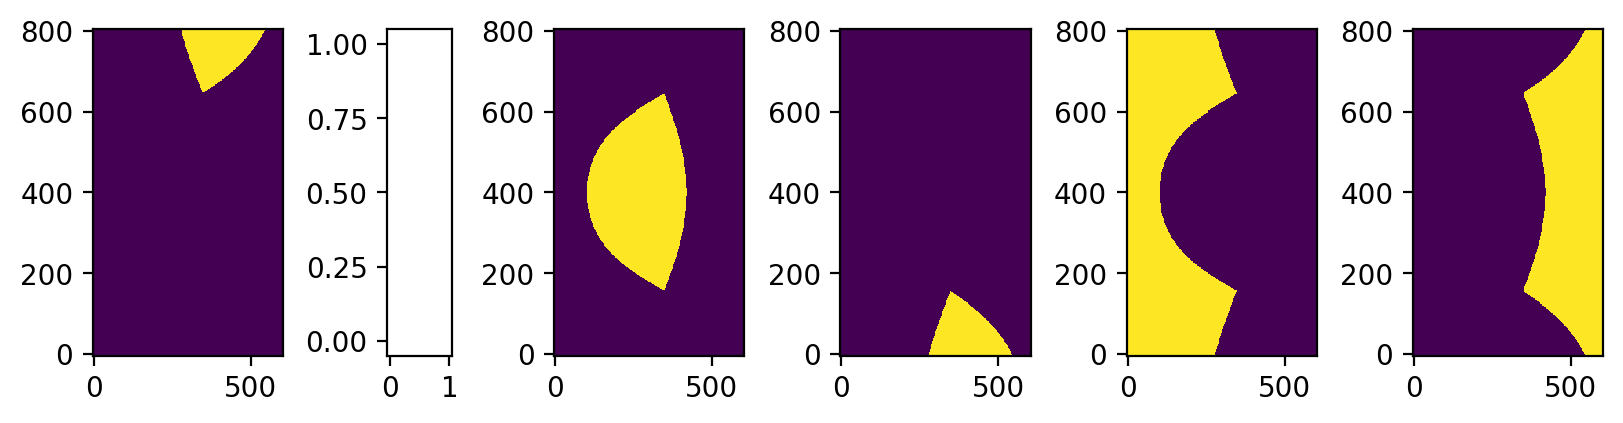

In [6]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=5,  figsize=(8, 2),  dpi=200, constrained_layout=True)

cs1 = axes[0].pcolormesh(X, Y, inside_mask_top, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, inside_mask_center, cmap='viridis')
cs3 = axes[2].pcolormesh(X, Y, inside_mask_bottom, cmap='viridis')
cs4 = axes[3].pcolormesh(X, Y, left_outside_mask, cmap='viridis')
cs5 = axes[4].pcolormesh(X, Y, right_outside_mask, cmap='viridis')

cbar1=fig.colorbar(cs1, ax=axes[0])
cbar2=fig.colorbar(cs2, ax=axes[1])
cbar3=fig.colorbar(cs3, ax=axes[2])
cbar1.ax.tick_params(labelsize=5); cbar2.ax.tick_params(labelsize=5); cbar3.ax.tick_params(labelsize=5) 

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
axes[0].set_title('Top mask', fontsize=10)
axes[1].set_title('Center mask', fontsize=10)
axes[2].set_title('Bottom mask', fontsize=10)
axes[3].set_title('Left mask', fontsize=10)
axes[4].set_title('Right mask', fontsize=10)

#plt.gca().set_aspect('equal')
plt.show(block=False)

# Source integration inside the separatrix

In [7]:
dA= s.dx * s.dy
rorho_s = s.attribute['rorho_s']

# Calculate the integral by summing the product of Bpol values and dA over the masked region
Sn_tot = np.sum(Sn[inside_mask_center] * dA/rorho_s)
St_tot = np.sum(St[inside_mask_center] * dA/rorho_s)
Sp_tot = np.sum(Sp[inside_mask_center] * dA/rorho_s)
            
print("The integrtation of density source", '\n=', np.round(Sn_tot,3))
print("The integrtation of temperature source", '\n=', np.round(St_tot,3))
print("The integrtation of power source", '\n=',np.round(Sp_tot,3))

The integrtation of density source 
= 20.825
The integrtation of temperature source 
= 14.9
The integrtation of power source 
= 40.302
